# Scelta del modello migliore
In questo notebook testeremo diversi modelli.

Un volta identificato il migliore proseguiremo con il tuning dei parametri.

Infine vedremo come effettuare una validazione più robusta del modello ottimizzato.

In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [3]:
df = pd.read_pickle("../data/weather/processed_weather_data.pkl")

In [4]:
# Individuo alcune colonne su cui addestrare il modello
TRAIN_COLS = [
    'Precip',
    'MaxTemp', 
    'MinTemp'
]

# TARGET DEFINITION
TARGET_COL = "Snowfall"

In [5]:
X = df[TRAIN_COLS]
y = df[TARGET_COL]

In [6]:
# train / test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [7]:
X_train.shape, X_test.shape

((89256, 3), (29752, 3))

### TRY DIFFERENT ALGORITHMS

In [8]:
colnames = X_train.columns.tolist()

def get_model():
    # definizione delle trasformazioni delle colonne
    imputer = SimpleImputer(strategy="median") # se ci sono valori mancanti li sostituisce con la mediana (su tutte le colonne)

    std_scaler_columns = [colnames.index(x) for x in ["MinTemp", "MaxTemp"]]
    minmax_scaler_columns = [colnames.index(x) for x in ["Precip"]]
    ct = ColumnTransformer([
        ("stdscaler", StandardScaler(), std_scaler_columns), # applica standard scaler solo a Min e Max Temp
        ("minmaxscaler", MinMaxScaler(), minmax_scaler_columns) # applica il MinMax Scaler a Precip
    ], remainder='passthrough') 

    # definizione del estimator (regressore)
    regressor = LinearRegression()  

    # creazione della pipeline
    pipe = Pipeline(steps=[
        ("imputer", imputer), 
        ("col_transformer", ct), 
        ("regressor", None)
    ])
    
    return pipe

In [9]:
param_grid = {
    'regressor': [
        LinearRegression(),
        Ridge(alpha=0.5, random_state=42),
        Lasso(alpha=0.5, random_state=42),
        RandomForestRegressor(max_depth=5, random_state=42)
    ]
}

In [10]:
search = GridSearchCV(
    get_model(), 
    param_grid, 
    cv=KFold(n_splits=5, shuffle=True, random_state=123), 
    scoring="neg_mean_squared_error",
    return_train_score=True, 
    verbose=3
)

In [11]:
%%time
search.fit(X, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END regressor=LinearRegression();, score=(train=-6.176, test=-5.818) total time=   0.0s
[CV 2/5] END regressor=LinearRegression();, score=(train=-6.102, test=-6.112) total time=   0.0s
[CV 3/5] END regressor=LinearRegression();, score=(train=-6.200, test=-5.722) total time=   0.0s
[CV 4/5] END regressor=LinearRegression();, score=(train=-5.960, test=-6.683) total time=   0.0s
[CV 5/5] END regressor=LinearRegression();, score=(train=-6.082, test=-6.192) total time=   0.0s
[CV 1/5] END regressor=Ridge(alpha=0.5, random_state=42);, score=(train=-6.176, test=-5.818) total time=   0.1s
[CV 2/5] END regressor=Ridge(alpha=0.5, random_state=42);, score=(train=-6.102, test=-6.112) total time=   0.0s
[CV 3/5] END regressor=Ridge(alpha=0.5, random_state=42);, score=(train=-6.200, test=-5.722) total time=   0.0s
[CV 4/5] END regressor=Ridge(alpha=0.5, random_state=42);, score=(train=-5.960, test=-6.683) total time=   0.0s
[CV 5/5

GridSearchCV(cv=KFold(n_splits=5, random_state=123, shuffle=True),
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('col_transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('stdscaler',
                                                                         StandardScaler(),
                                                                         [2,
                                                                          1]),
                                                                        ('minmaxscaler',
                                                                         MinMaxScaler(),
                                                                         [0])])),
                                       ('regressor', None)]),
          

In [12]:
search.best_estimator_

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('col_transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('stdscaler', StandardScaler(),
                                                  [2, 1]),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(), [0])])),
                ('regressor',
                 RandomForestRegressor(max_depth=5, random_state=42))])

In [13]:
search.best_score_

-4.683016134096068

#### BEST ALGORITHM = RandomForestRegressor

In [14]:
search.cv_results_

{'mean_fit_time': array([0.06680145, 0.12100272, 0.0984046 , 5.37712636]),
 'std_fit_time': array([0.00541935, 0.05355088, 0.00407416, 0.38939227]),
 'mean_score_time': array([0.00620227, 0.00839953, 0.00599785, 0.07659492]),
 'std_score_time': array([0.00074673, 0.00313799, 0.00126497, 0.00638233]),
 'param_regressor': masked_array(data=[LinearRegression(), Ridge(alpha=0.5, random_state=42),
                    Lasso(alpha=0.5, random_state=42),
                    RandomForestRegressor(max_depth=5, random_state=42)],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'regressor': LinearRegression()},
  {'regressor': Ridge(alpha=0.5, random_state=42)},
  {'regressor': Lasso(alpha=0.5, random_state=42)},
  {'regressor': RandomForestRegressor(max_depth=5, random_state=42)}],
 'split0_test_score': array([-5.81813619, -5.81813595, -6.01295601, -4.56200847]),
 'split1_test_score': array([-6.11163221, -6.11163186, -6.32395328, -

In [15]:
search.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_regressor', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])

In [16]:
[r["regressor"].__class__.__name__ for r in search.cv_results_["params"]]

['LinearRegression', 'Ridge', 'Lasso', 'RandomForestRegressor']

In [17]:
plot_res_df = pd.DataFrame([
    search.cv_results_['split0_test_score'], 
    search.cv_results_['split1_test_score'],
    search.cv_results_['split2_test_score'], 
    search.cv_results_['split3_test_score'], 
    search.cv_results_['split4_test_score']
], columns=[r["regressor"].__class__.__name__ for r in search.cv_results_["params"]])

<AxesSubplot:xlabel='Fold', ylabel='TestScore'>

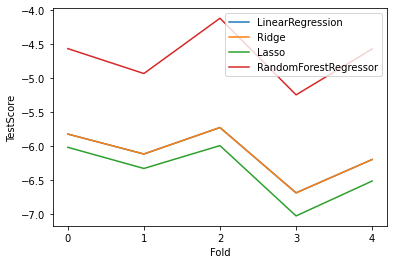

In [18]:
plot_res_df.plot(xlabel="Fold", ylabel="TestScore", xticks=range(plot_res_df.shape[1]+1))

### Esercizio: HYPER PARAMETER TUNING

Con la stessa metodologia esposta è possibile fare tuning parametri.
Lascio a voi questo esercizio.

Suggerimenti: 
- provare a lavorare sui seguenti parametri dell'algoritmo RandomForest
    - max_depth
    - min_samples_split
    - min_samples_leaf
- random forest è un algoritmo basato su alberi, teoricamente non richiede scaling delle features
- è possibile eseguire nuovamente la selezione del modello e tuning dei parametri aggiungendo nuove colonne (vedi pairplot nel notebook precedente)

In [19]:
# param_grid = {
#     'base_estimator__max_depth': [2, 4, 6, 8, 12]
#     .......
# }

In [20]:
# search = GridSearchCV(.........)
# search.fit(X, y)